# Notebook to create the lateral forcing myself



#### xESMF
Use xesmf (https://pangeo-xesmf.readthedocs.io/en/latest/index.html)

Use similar method as https://github.com/trondkr/model2roms

Use a 1/4° NWES grid provided by Dewi: 'NorthSea4_smooth01_sponge_nudg.nc'



#### Regridding steps
First regrid all variables (zos, uo, vo, thetao, so) from cartesian (lat, lon) to RHO points (eta_rho, xi_rho) for each Z-level. 
Zos only has surface values and therefore only 2D coordinates. Thereafter, the velocities uo, vo have to be interpolated to respectively (eta_u, xi_u) and (eta_v, xi_v) When the horizontal interpolation is done for all variables, the Z-levels are interpolated to sigma levels.










#### Use masks
xESMF treats NaNs like regular values hence potentially resulting in missing values bleeding into the regridded field and creating insconsistencies in the resulting masked array. To overcome this issue, we can use explicit masking of the source and target grids.


Be carefull that the mask is different for different depth levels and therefore the horizontal regridding should be done for each depth level seperately. Trond does not take into account depth varying mask when regridding. Also, the roms grid does not include a mask that varies for depth levels.



Remember to change NaN values to fillvalue

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import numpy as np
import datetime
import time

In [2]:
# Import grid

grid = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/grid/NorthSea4_smooth01_sponge_nudg.nc')

In [3]:
# Import data
glorys = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS12V1/processed/glorys.nc')


data = glorys
data_type = 'GLORYS' # Choose 'GLORYS' or 'ORA20C'

# Sort coordinates in increasing order
data = data.sortby(['depth', 'latitude', 'longitude'])

In [4]:
# Import Tim lateral forcing files
ini_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/timnorthsea8/NS8_ForcingSmooth01/NS8_init_GLORYS_19930115_to_20021231.nc')
clim_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/timnorthsea8/NS8_ForcingSmooth01/NS8_clim_GLORYS_19930115_to_20021231.nc')
bry_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/timnorthsea8/NS8_ForcingSmooth01/NS8_bry_GLORYS_19930115_to_20021231.nc')

### Show the grid

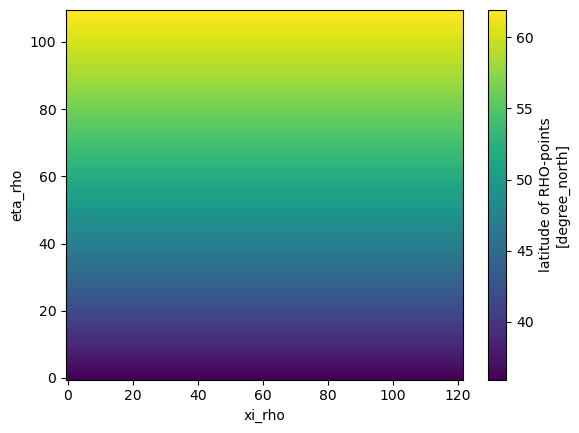

In [5]:
grid.lat_rho.plot()

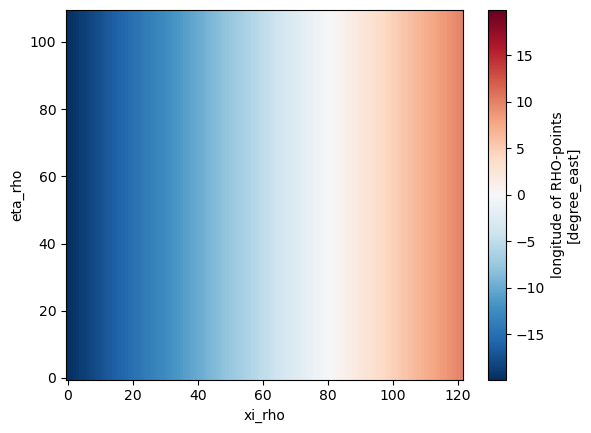

In [6]:
grid.lon_rho.plot()

In [7]:
data

<xarray.Dataset>
Dimensions:    (time: 324, depth: 50, latitude: 409, longitude: 457)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2019-12-16T12:00:00
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 32.0 32.08 32.17 32.25 ... 65.83 65.92 66.0
  * longitude  (longitude) float32 -24.0 -23.92 -23.83 ... 13.83 13.92 14.0
Data variables:
    so         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Perform the horizontal interpolation

In [8]:
# Create output grids

output_grid_rho = xr.Dataset(data_vars=dict(mask=(["eta_rho", "xi_rho"], grid.mask_rho.values),), 
                           coords=dict(eta_rho=(["eta_rho"], grid.eta_rho.values),
                                       xi_rho=(["xi_rho"], grid.xi_rho.values),
                                       lat=(["eta_rho", "xi_rho"], grid.lat_rho.values),
                                       lon=(["eta_rho", "xi_rho"], grid.lon_rho.values),
                                      ))

output_grid_u = xr.Dataset(data_vars=dict(mask=(["eta_u", "xi_u"], grid.mask_u.values),), 
                           coords=dict(eta_u=(["eta_u"], grid.eta_u.values),
                                       xi_u=(["xi_u"], grid.xi_u.values),
                                       lat=(["eta_u", "xi_u"], grid.lat_u.values),
                                       lon=(["eta_u", "xi_u"], grid.lon_u.values),
                                      ))


output_grid_v = xr.Dataset(data_vars=dict(mask=(["eta_v", "xi_v"], grid.mask_v.values),), 
                           coords=dict(eta_u=(["eta_v"], grid.eta_v.values),
                                       xi_u=(["xi_v"], grid.xi_v.values),
                                       lat=(["eta_v", "xi_v"], grid.lat_v.values),
                                       lon=(["eta_v", "xi_v"], grid.lon_v.values),
                                      ))





def plot_masks(input_grid, output_grid, coord = 'RHO'):
    ''' 
    Function to plot the mask used for the reanalysis data and the ROMS grid.
    '''
    
    
    fig, axes = plt.subplots(ncols = 2, figsize = (8,3))
    
    input_grid.mask.plot(ax = axes[0], cmap = 'binary_r', )
    output_grid.mask.plot(ax = axes[1], cmap = 'binary_r')
    
    axes[0].set_title(f'Mask of reanalysis data for {coord}-coordinates')
    axes[1].set_title(f'Mask of ROMS grid for {coord}-coordinates')
    
    plt.tight_layout()


    
def horizontal_interp1D(input_data, var):
    ''' 
    Function to perform the horizontal regridding per depth level
    
    '''
    
    
    if var == 'thetao':
        
        output_grid = output_grid_rho
    
    elif var == 'uo':
        
        output_grid = output_grid_u
        
    else:
        
        output_grid = output_grid_v
    
  
    
    # Prepare the input grid
    input_grid = xr.Dataset(data_vars=dict(mask=(["lat", "lon"], np.nan_to_num(input_data[0, :, :] / input_data[0, :, :])),), 
                           coords=dict(time=(["time"], data.time.values),
                                       lat=(["lat"], data.latitude.values),
                                       lon=(["lon"], data.longitude.values),
                                      ))
    
    
    # Make arrays C_CONTIGUOUS
    input_grid = input_grid.astype(dtype = 'int64', order = 'C')
    output_grid = output_grid.astype(dtype = 'float64', order = 'C')
    
    
        
    # Build regridder
    regridder = xe.Regridder(input_grid, output_grid, "bilinear", extrap_method= 'nearest_s2d')


    # Apply to data
    output_data = regridder(input_data)
    
    
    return output_data
    
    
    
def horizontal_interp(input_data, grid, map_masks = False):
    ''' Function to perform the horizontal interpolation from latitude, longitude coordinates to (eta_rho, xi_rho), (eta_u, xi_u) or (eta_v, xi_v). 
        The horizontal interpolation is performed as a linear interpolation.
        
        The glorys data with a resolution of 1/12° or the ora data with a resolution of 1.0° is regridded on the ROMS grid that has a resolution of 1/4°.
        
        '''
    start_time = time.time()
    
    
    # Some data preparations
    
    # Rename coordinates to 'lat' and 'lon'
    input_data = input_data.rename({'latitude':'lat', 'longitude':'lon', 'time':'time'})

    # Sort coordinates in increasing order
    input_data = input_data.sortby(['lat', 'lon'])

    # Transpose dimensions
    input_data = input_data.transpose('depth', 'time', 'lat', 'lon')
    
    

    
    # Regrid Sea level to 'rho'-coordinates
    print(f'===================== Start horizontal interpolation of Sea Level (Duration: {round(time.time() - start_time,2)} seconds) ========================================================')
    
    
    data_rho = input_data.drop(['uo', 'vo', 'thetao', 'so'])
    
    
    # Prepare the output grid
    output_grid = xr.Dataset(data_vars=dict(mask=(["eta_rho", "xi_rho"], grid.mask_rho.values),), 
                           coords=dict(eta_rho=(["eta_rho"], grid.eta_rho.values),
                                       xi_rho=(["xi_rho"], grid.xi_rho.values),
                                       lat=(["eta_rho", "xi_rho"], grid.lat_rho.values),
                                       lon=(["eta_rho", "xi_rho"], grid.lon_rho.values),
                                      ))
    
  
    # Prepare the input grid
    input_grid = xr.Dataset(data_vars=dict(mask=(["lat", "lon"], xr.where(~np.isnan(data_rho.zos.isel(time=0)), 1, 0).values),), 
                           coords=dict(time=(["time"], data_rho.time.values),
                                       lat=(["lat"], data_rho.lat.values),
                                       lon=(["lon"], data_rho.lon.values),
                                      ))


    # Make arrays C_CONTIGUOUS
    input_grid = input_grid.astype(dtype = 'int64', order = 'C')
    output_grid = output_grid.astype(dtype = 'float64', order = 'C')
    
    if map_masks:
        
        plot_masks(input_grid, output_grid, 'RHO')
        
        
    # Build regridder
    regridder = xe.Regridder(input_grid, output_grid, "bilinear", extrap_method= 'nearest_s2d')


    # Apply to data
    output_data_rho_zos = regridder(data_rho)
    





    # Regrid Salinity and Temperature to 'rho'-coordinates
    print(f'===================== Start horizontal interpolation of Salinity and Temperature (Duration: {round(time.time() - start_time,2)} seconds) =========================================')
    
    data_rho_ST = input_data.drop(['uo', 'vo', 'zos'])
    
    
    # Perform regridding parallel
    output_data_rho_ST = xr.apply_ufunc(horizontal_interp1D,
                                       data_rho_ST, 'thetao',
                                       input_core_dims=[['time', 'lat', 'lon'], []],
                                       output_core_dims = [['time', 'eta_rho', 'xi_rho']],
                                       dask = 'parallelized',
                                       output_dtypes = [data_rho_ST.thetao.dtype],
                                       vectorize = True)
    
    output_data_rho_ST = output_data_rho_ST.assign_coords(eta_rho = grid.eta_rho, xi_rho = grid.xi_rho)
    
    
    # Regrid Zonal velocities to 'u'-coordinates
    print(f'===================== Start horizontal interpolation of Zonal Velocity (Duration: {round(time.time() - start_time,2)} seconds) ====================================================')
    
    data_u = input_data.drop(['so', 'thetao', 'vo', 'zos'])
    
    
    # Perform regridding parallel
    output_data_u = xr.apply_ufunc(horizontal_interp1D,
                                       data_u, 'uo',
                                       input_core_dims=[['time', 'lat', 'lon'], []],
                                       output_core_dims = [['time', 'eta_u', 'xi_u']],
                                       dask = 'parallelized',
                                       output_dtypes = [data_u.uo.dtype],
                                       vectorize = True)
    
    
    output_data_u = output_data_u.assign_coords(eta_u = grid.eta_u, xi_v = grid.xi_u)
    
    
    
    # Regrid Meridional velocities to 'v'-coordinates
    print(f'===================== Start horizontal interpolation of Meridional Velocity (Duration: {round((time.time() - start_time),2)} seconds) =============================================')
    
    
    data_v = input_data.drop(['so', 'thetao', 'uo', 'zos'])
    
    
    
    # Perform regridding parallel
    output_data_v = xr.apply_ufunc(horizontal_interp1D,
                                       data_v, 'vo',
                                       input_core_dims=[['time', 'lat', 'lon'], []],
                                       output_core_dims = [['time', 'eta_v', 'xi_v']],
                                       dask = 'parallelized',
                                       output_dtypes = [data_v.vo.dtype],
                                       vectorize = True)
    
    
    output_data_v = output_data_v.assign_coords(eta_v = grid.eta_v, xi_v = grid.xi_v)
    
    
    # Create one final dataset
    print('===================== Finalised horizontal interpolation, creating final dataset ==============================================')
    
    
    # Create one horizontally regridded file
    output_data = output_data_rho_ST.copy()

    # Add zos, uo and vo
    output_data = output_data.assign(zos=output_data_rho_zos.zos)
    output_data = output_data.assign(uo=output_data_u.uo)
    output_data = output_data.assign(vo=output_data_v.vo)

    
    output_data.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/data_hr_test.nc')
    
    return output_data

In [ ]:
data_hr = horizontal_interp(data, grid, map_masks = False)

===================== Start horizontal interpolation of Sea Level (Duration: 0.0 seconds) ========================================================
===================== Start horizontal interpolation of Salinity and Temperature (Duration: 2.98 seconds) =========================================


## Check results

#### Check sea level

In [ ]:
# Some settings
time_step = 0


# Create figures
fig, axes = plt.subplots(ncols = 3, figsize = (15,3.5))


data.zos.isel(time=time_step).plot(ax = axes[0])
data_hr.zos.isel(time=time_step).plot(ax = axes[1], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')
clim_tim.zeta.isel(ocean_time=time_step).plot(ax = axes[2], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')

axes[0].set_title(f'{data_type} reanalysis data (1.0°) \n {data.time.isel(time=time_step).dt.date}')
axes[1].set_title(f'Horizontally regridded data (1/4°)\n {data_hr.time.isel(time=time_step).dt.date}')
axes[2].set_title(f'Climatology forcing Tim (1/8°)\n {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}')
    
plt.tight_layout()


In [ ]:
# Some settings
time_step = -1


# Create figures
fig, axes = plt.subplots(ncols = 3, figsize = (15,3.5))


data.zos.isel(time=time_step).plot(ax = axes[0])
data_hr.zos.isel(time=time_step).plot(ax = axes[1], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')
clim_tim.zeta.isel(ocean_time=time_step).plot(ax = axes[2], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')

axes[0].set_title(f'{data_type} reanalysis data (1.0°) \n {data.time.isel(time=time_step).dt.date}')
axes[1].set_title(f'Horizontally regridded data (1/4°)\n {data_hr.time.isel(time=time_step).dt.date}')
axes[2].set_title(f'Climatology forcing Tim (1/8°)\n {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}')
    
plt.tight_layout()


The horizontal regridding of sea level seems to be succesfull!

### Check temperature and salinity

In [ ]:
# Some settings
time_step = 0


# Create figures
nrows = data.depth.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Plot Temperature maps
    
    data.thetao.isel(time = time_step, depth = i).plot(ax = axes[i, 0], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
    
    if i == 0:
        axes[i, 0].set_title(f'{data_type} reanalysis data  \n time =  {data.time.isel(time=time_step).dt.date}\n depth = {int(data.depth.isel(depth = i))}m')
    else:
        axes[i, 0].set_title(f'depth = {int(data.depth.isel(depth = i))}m')
    
    data_hr.thetao.isel(time = time_step, depth = i).plot(ax = axes[i, 1], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Horizontally regridded data  \n time =  {data_hr.time.isel(time=time_step).dt.date}\n depth = {int(data_hr.depth.isel(depth = i))}m')
    else:
        axes[i, 1].set_title(f'depth = {int(data_hr.depth.isel(depth = i))}m')
    
    
    
    # Plot Salinity maps
    
    
    data.so.isel(time = time_step, depth = i).plot(ax = axes[i, 2], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
    
    if i == 0:
        axes[i, 2].set_title(f'{data_type} reanalysis data  \n time =  {data.time.isel(time=time_step).dt.date}\n depth = {int(data.depth.isel(depth = i))}m')
    else:
        axes[i, 2].set_title(f'depth = {int(data.depth.isel(depth = i))}m')
    
    data_hr.so.isel(time = time_step, depth = i).plot(ax = axes[i, 3], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Horizontally regridded data  \n time =  {data_hr.time.isel(time=time_step).dt.date}\n depth = {int(data_hr.depth.isel(depth = i))}m')
    else:
        axes[i, 3].set_title(f'depth = {int(data_hr.depth.isel(depth = i))}m')
    
    
plt.tight_layout()

In [ ]:
data_hr.thetao.isel(depth=41)

The deepest values are all nan

### Check zonal and meridional velocities

In [ ]:
# Some settings
time_step = 0


# Create figures
nrows = data.depth.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    axes[i,2].set_facecolor('lightgray')
    axes[i,3].set_facecolor('lightgray')
    
    
    
    # Plot Temperature maps
    
    data.uo.isel(time = time_step, depth = i).plot(ax = axes[i, 0], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
    
    
    if i == 0:
        axes[i, 0].set_title(f'{data_type} reanalysis data  \n time =  {data.time.isel(time=time_step).dt.date}\n depth = {int(data.depth.isel(depth = i))}m')
    else:
        axes[i, 0].set_title(f'depth = {int(data.depth.isel(depth = i))}m')
    
    data_hr.uo.isel(time = time_step, depth = i).plot(ax = axes[i, 1], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Horizontally regridded data  \n time =  {data_hr.time.isel(time=time_step).dt.date}\n depth = {int(data_hr.depth.isel(depth = i))}m')
    else:
        axes[i, 1].set_title(f'depth = {int(data_hr.depth.isel(depth = i))}m')
    
    
    
    # Plot Salinity maps
    
    
    data.vo.isel(time = time_step, depth = i).plot(ax = axes[i, 2], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'{data_type} reanalysis data  \n time =  {data.time.isel(time=time_step).dt.date}\n depth = {int(data.depth.isel(depth = i))}m')
    else:
        axes[i, 2].set_title(f'depth = {int(data.depth.isel(depth = i))}m')
    
    data_hr.vo.isel(time = time_step, depth = i).plot(ax = axes[i, 3], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Horizontally regridded data  \n time =  {data_hr.time.isel(time=time_step).dt.date}\n depth = {int(data_hr.depth.isel(depth = i))}m')
    else:
        axes[i, 3].set_title(f'depth = {int(data_hr.depth.isel(depth = i))}m')
    
    
plt.tight_layout()

The deepest values are only nan

## Apply La Place filter

In [ ]:
def create_grdMODEL(data):
    ''' Function to create the dataset grdMODEL '''
    
    grdMODEL = data.copy().drop(['thetao', 'so', 'uo', 'vo'])
    
    grdMODEL['lon'] = data.lon
    grdMODEL['lat'] = data.lat
    grdMODEL['h'] = data.depth
    grdMODEL['nlevels'] = grdMODEL.h.size
    
    
    grdMODEL['fillval'] = -32767   # Change for ORA-20C
    grdMODEL['hc'] = None

    # Create grid for ESMF interpolation, probably not needed for VT

    grdMODEL['z_r'] = -grdMODEL.h

    grdMODEL['grdType'] = 'regular'
    grdMODEL['lonName'] = 'longitude'
    grdMODEL['latName'] = 'latitude'
    grdMODEL['depthName'] = 'depth'


    grdMODEL['Lp'] = len(grdMODEL.lat[1,:])
    grdMODEL['Mp'] = len(grdMODEL.lat[:,1])

    grdMODEL['L'] = grdMODEL.Lp - 1
    grdMODEL['M'] = grdMODEL.Mp - 1
    
    
    
    return grdMODEL

def create_grdROMS(grid):
    ''' Function to create the dataset grdROMS '''
    
    # Create the dataset grdROMS

    # Copy the roms grid
    grdROMS = grid.copy()

    # Drop unnecessary variables
    grdROMS = grdROMS.drop(['tracer_NudgeCoef', 'diff_factor', 'visc_factor', 'hraw', 'f', 'spherical'])



    # Add below variables to grdROMS
    grdROMS['write_clim'] = True
    grdROMS['write_bry'] = True
    grdROMS['write_init'] = True
    grdROMS['write_stations'] = False
    grdROMS['lonname'] = 'lon_rho'
    grdROMS['latname'] = 'lat_rho'
    grdROMS['inittime'] = 0                    # Set initTime to 1 if you dont want the first time-step to be the initial field (no ubar and vbar if time=0)
    grdROMS['ocean_time'] = 0
    grdROMS['NT'] = 2
    grdROMS['tracer'] = grdROMS.NT
    grdROMS['time'] = 0                      
    grdROMS['reftime'] = 0
    grdROMS['grdtype'] = 'regular'

    grdROMS['masked_h'] = grdROMS.h.where(grdROMS.h > 0, grdROMS.h, grdROMS.h.max())
    grdROMS['hmin'] = grdROMS.masked_h.min()

    grdROMS['vtransform'] = 2
    grdROMS['vstretching'] = 4

    grdROMS['nlevels'] = grdROMS.s_rho.size

    grdROMS['zeta'] = (('eta_rho', 'xi_rho'), np.zeros(grdROMS.h.shape))

    grdROMS['invpm'] = 1.0 / grdROMS.pm
    grdROMS['invpn'] = 1.0 / grdROMS.pn

    grdROMS['Lp'] = grdROMS.lat_rho[1,:].size     
    grdROMS['Mp'] = grdROMS.lat_rho[:,1].size     

    grdROMS['fillval'] = -9.99e33

    grdROMS['eta_rho_'] = grdROMS.Mp
    grdROMS['eta_u_'] = grdROMS.Mp
    grdROMS['eta_v_'] = grdROMS.Mp - 1
    grdROMS['eta_psi_'] = grdROMS.Mp - 1


    grdROMS['xi_rho_'] = grdROMS.Lp
    grdROMS['xi_u_'] = grdROMS.Lp - 1
    grdROMS['xi_v_'] = grdROMS.Lp
    grdROMS['xi_psi_'] = grdROMS.Lp - 1



    # Obtain s_rho

    c1 = 1.0
    c2 = 2.0
    p5 = 0.5

    lev = np.arange(1, int(grdROMS.nlevels) + 1, 1)
    ds = 1.0 / int(grdROMS.nlevels)


    grdROMS['s_rho_'] = - c1 + (lev - p5) * ds


    # Obtain s_w

    lev = np.arange(0, int(grdROMS.nlevels), 1)
    ds = 1.0 / (int(grdROMS.nlevels) - 1)


    grdROMS['s_w_'] = - c1 + (lev - p5) * ds




    # Obtain Cs_r

    if (grdROMS.theta_s > 0):
        Csur = (c1 - np.cosh(grdROMS.theta_s * grdROMS.s_rho)) / (np.cosh(grdROMS.theta_s) - c1)

    else:
        Csur = -grdROMS.s_rho**2

    if (grdROMS.theta_b > 0):
        Cbot = (np.exp(grdROMS.theta_b * Csur) - c1 ) / (c1 - np.exp(-grdROMS.theta_b))
        grdROMS['Cs_r'] = Cbot
    else:
        grdROMS['Cs_r'] = Csur     



    # Obtain Cs_w

    if (grdROMS.theta_s > 0):
        Csur = (c1 - np.cosh(grdROMS.theta_s * grdROMS.s_w)) / (np.cosh(grdROMS.theta_s) - c1)

    else:
        Csur = -grdROMS.s_w**2

    if (grdROMS.theta_b > 0):
        Cbot = (np.exp(grdROMS.theta_b * Csur) - c1 ) / (c1 - np.exp(-grdROMS.theta_b))
        grdROMS['Cs_w'] = Cbot
    else:
        grdROMS['Cs_w'] = Csur     




    # Obtain z_r

    z0 = (grdROMS.hc * grdROMS.s_rho + grdROMS.h * grdROMS.Cs_r) / (grdROMS.hc + grdROMS.h)
    grdROMS['z_r'] = grdROMS.zeta + (grdROMS.zeta + grdROMS.h) * z0



    # Obtain z_w

    z0 = (grdROMS.hc * grdROMS.s_w + grdROMS.h * grdROMS.Cs_w) / (grdROMS.hc + grdROMS.h)
    grdROMS['z_w'] = grdROMS.zeta + (grdROMS.zeta + grdROMS.h) * z0



    # Also ESMF grid is added but probably not needed for VT



    grdROMS['L'] = grdROMS.Lp -1
    grdROMS['M'] = grdROMS.Mp -1

    
    
    
    
    return grdROMS





## Understand what will happen in the vertical transformation

### Show bathymetry

In [ ]:
bathymetry = -grid.h

In [ ]:
bathymetry.plot()

In [ ]:
# Create reanalysis data and ROMS input grids
grdMODEL = create_grdMODEL(data_hr)
grdROMS = create_grdROMS(grid)
bathymetry = grdROMS.h
zr = grdROMS.z_r
zs = grdMODEL.z_r
Nroms = grdROMS.nlevels
Ndata = grdMODEL.nlevels


zr = zr.sortby('s_rho', ascending = False)

In [ ]:
zr[:,:,-1].where(zr[:,:,-1] < zs[Ndata - 1]).plot()

In [ ]:
print(f'For case 1, a ROMS grid depth layer is deeper than the deepest data depth layer. However, the deepest data depth layer is zs[Ndata - 1]={zs[Ndata - 1].values}m\n whereas the deepest depth in the ROMS grid is zr[:,:,-1].min()={zr[:,:,-1].min()}m.\n Case 1 will thus not happen.')


In [ ]:
zr[:,:,0:12].where(zr[:,:,0:12] > zs[0]).plot(col='s_rho', col_wrap = 6, vmin = -5, vmax = 0)

In [ ]:
print(f'For case 2, a ROMS grid depth layer is shallower than the shallowest data depth layer. The shallowest data depth layers is zs[0]={zs[0].values}m.\n For the shallowest 10 ROMS grid layers there are locations with depths shallower than the shallowest data depth.\n Case 2 will thus happen for these situations.')


In [ ]:
bottom = -1*bathymetry
bottom.plot()

In [ ]:
zs.size

In [ ]:
fig, axes = plt.subplots(nrows = zs.size, figsize = (4,3*zs.size))

for k in range(zs.size):
    bottom.where(zs[k] < bottom).plot(ax = axes[k])
    
plt.tight_layout()

In [ ]:
print(f'For case 3, a ROMS grid depth layer is deeper than some data depth layer but shallower than the next data depth layer which is below bathymetry.\n Already for the shallower areas, the shallower (thirds) data depth layers are already below the bathymetry. All deeper data depth layers are below some part of the bathymetry.\n The deepest data depth layers is almost completely below the bathymetry but for some grid points the bathymetry is still deeper.')

In [ ]:
fill = -10000 
print(f'Case 4 assumes that there are values of the reanalysis data smaller than fill={fill}. However, the smallest value are:\n {data_hr.min()}. \n Case 4 will thus not happen.')

In [ ]:
print(f'Case 5 will happen most of the time where a ROMS depth layer lies in between two data depth layers. A weighted average of both data points is used.')

## Perform the vertical transformation

In [ ]:
def obtain_VT_data(input_data, zr, bathymetry, zs, Nroms, Ndata, fill):
    ''' Function to obtain the vertical transformed data for a certain depth layer and grid location of the ROMS grid. A time series is returned. '''
    
    outdat = np.empty(Nroms)
    
    
    for kc in range(int(Nroms)): # Loop over ROMS depth layers (30)
        
    
        # Case 1: ROMS is deeper than GLORYS. This part searches for deepest good value if ROMS depth is deeper than GLORYS. 
        # This means that if no value, or only fill_value, is available from GLORYS where ROMS is deepest, the closest value from GLORYS is found by looping upward in the water column.

        # Between GLORYS/ORA and ROMS grid, CASE 1 will never happen
        if zr[kc] < zs[Ndata - 1]:
            
            
            outdat[kc] = input_data[Ndata - 1]
            
            
            #We do not want to give the deepest depth to be nan
            
            if not np.isnan(np.sum(input_data)):  

                if np.isnan(input_data[Ndata - 1]): 
                    
                    for kT in range(int(Ndata)):

                        if not np.isnan(input_data[Ndata - 1 - kT]):

                            outdat[kc] = input_data[Ndata - 1 - kT]


        # Case 2: ROMS depth layer is shallower than GLORYS depth layer. 

        elif zr[kc] > zs[0]:   
            
            
            outdat[kc] = input_data[0]
            

        else:

            for kT in range(int(Ndata) - 1): # Do loop between surface and bottom of GLORYS depth layers, - 1 because we also check for the next GLORYS layer each step

                # Case 3: ROMS depth layer is deeper than some GLORYS depth layer, but shallower than the next GLORYS layer which is below bottom 

                if (zr[kc] <= zs[kT]) & (-(bathymetry) > zs[kT + 1]):
                    
                    
                    outdat[kc] = input_data[kT]
                    
                        
                    #We do not want to give the deepest depth a nan value
                    
                    if not np.isnan(np.sum(input_data)):  

                        if np.isnan(input_data[Ndata - 1]): 

                            print(f'Case 3: deepest depth is nan. kc={kc}')
                            for kkT in range(int(Ndata)):

                                if not np.isnan(input_data[kT - kkT]):
                                    
                                    outdat[kc] = input_data[kT - kkT]
                
                # Case 4: Special case where ROMS layers are much deeper than in reanalysis data
                
                elif (zr[kc] <= zs[kT]) & np.invert(np.isnan(input_data[kT])) & np.isnan(input_data[kT + 1])  :
                    
                    outdat[kc] = input_data[kT]

            

                # Case 5: ROMS layer in between two reanalysis data layers. This is the typical case for most layers.

                elif (zr[kc] <= zs[kT]) & (zr[kc] >= zs[kT + 1]) & (-(bathymetry) <= zs[kT + 1]):

                    rz2 = abs((zr[kc] - zs[kT + 1]) / (abs(zs[kT + 1]) - abs(zs[kT])))

                    rz1 = 1.0 - rz2
                    
                    res = (rz1 * input_data[kT+1] + rz2 * input_data[kT])
                    
                    
                    outdat[kc] = res
                    
                    #We do not want to give nan value
                    if not np.isnan(np.sum(input_data)):  
                            
                            if np.isnan(input_data[kT]) or np.isnan(input_data[kT + 1]):
                                
                                print(f'Case 5: one of the values is nan. kc={kc}')
                                for kkT in range(Ndata):
                                            
                                    if not (np.isnan(input_data[kT-kkT])) & (np.isnan(input_data[kT - kkT + 1])):
                                        
                                        res = rz1 * input_data[kT + 1 - kkT] + rz2 * input_data[kT - kkT]
                                        
                                        outdat[kc] = res
                                        
                              
    return np.asarray(outdat)
                    
                    







def vertical_transf(data, grid):
    ''' Function to perform the vertical transformation.
    '''
    start_time = time.time()
    
    
    
    # Create reanalysis data and ROMS input grids
    grdMODEL = create_grdMODEL(data)
    grdROMS = create_grdROMS(grid)

    
    data = data.drop(['lat', 'lon']).rename({'zos': 'zeta'})                      
    
    
    
    print(f'===================== Start vertical transformation of variables with rho-coordinates (Duration: {round(time.time() - start_time,2)} seconds) ===================================')
    
    
    # Obtain variables
    bathymetry = grdROMS.h
    zr = grdROMS.z_r
    zs = grdMODEL.z_r
    Nroms = grdROMS.nlevels
    Ndata = grdMODEL.nlevels
    fill = -10000                                

    dat = data.copy()

    
    # Change the name of 'depth' and 's_rho' to 'z'
    dat = dat.rename({'depth' : 'z'})
    zs = zs.rename({'depth' : 'z'})
    zr = zr.rename({'s_rho' : 'z'})

    
    # Transpose dimensions
    zr = zr.transpose('z', 'eta_rho', 'xi_rho')
    bathymetry = bathymetry.transpose('eta_rho', 'xi_rho')


    # Change the arrangememnt of zr to make sure its ordered from surface to bottom
    zr = zr.sortby('z', ascending = False)
    
    
    
    
    print(f'===================== Start vertical transformation of Temperature (Duration: {round(time.time() - start_time,2)} seconds) ======================================================')
    
    dat_t = dat.thetao.transpose('z', 'time', 'eta_rho', 'xi_rho')
    
    
    theta_dataarray = xr.apply_ufunc(obtain_VT_data,                                                         # The function that should be executed
                             dat_t, zr, bathymetry, zs, Nroms, Ndata, fill,                                  # The arguments the function needs
                             input_core_dims=[['z'], ['z'], [], ['z'], [], [], []],                     # The list of core dimensions on each input argument that should not be broadcast
                             exclude_dims=set(('z',)), 
                             output_core_dims = [['z']],
                             dask = 'parallelized',
                             output_dtypes = [dat_t.dtype],
                             vectorize = True)
    
    theta_dataarray = theta_dataarray.rename('temp').rename({'z':'s_rho'}).assign_coords(s_rho = grid.s_rho.sortby('s_rho', ascending = False))
    
    
    print(f'===================== Start vertical transformation of Salinity (Duration: {round((time.time() - start_time)/60,0)} minutes) =========================================================')
    
    
    
    
    dat_s = dat.so.transpose('z', 'time', 'eta_rho', 'xi_rho')
    
    
    sali_dataarray = xr.apply_ufunc(obtain_VT_data,                                                          # The function that should be executed
                             dat_s, zr, bathymetry, zs, Nroms, Ndata, fill,                                  # The arguments the function needs
                             input_core_dims=[['z'], ['z'], [], ['z'], [], [], []],                          # The list of core dimensions on each input argument that should not be broadcast
                             exclude_dims=set(('z',)), 
                             output_core_dims = [['z']],
                             dask = 'parallelized',
                             output_dtypes = [dat_s.dtype],
                             vectorize = True)

    sali_dataarray = sali_dataarray.rename('salt').rename({'z':'s_rho'}).assign_coords(s_rho = grid.s_rho.sortby('s_rho', ascending = False))
    
    print(f'===================== Start vertical transformation of Zonal Velocity (Duration: {round((time.time() - start_time)/60,0)} minutes) ===================================================')
    
    # Change coordinate names such that apply_ufunc works correct
    dat_u = dat.uo.rename({'xi_u' : 'xi_rho', 'eta_u' : 'eta_rho'})
    
    dat_u = dat_u.transpose('z', 'time', 'eta_rho', 'xi_rho')
    
    # Since xi_u.size = 121 and xi_rho.size = 122, drop last values
    bathymetry_u = bathymetry[:, :-1]
    zr_u = zr[:, :, :-1]
    
    zonvel_dataarray = xr.apply_ufunc(obtain_VT_data,                                                        # The function that should be executed
                             dat_u, zr_u, bathymetry_u, zs, Nroms, Ndata, fill,                              # The arguments the function needs
                             input_core_dims=[['z'], ['z'], [], ['z'], [], [], []],                          # The list of core dimensions on each input argument that should not be broadcast
                             exclude_dims=set(('z',)), 
                             output_core_dims = [['z']],
                             dask = 'parallelized',
                             output_dtypes = [dat_u.dtype],
                             vectorize = True)

    zonvel_dataarray = zonvel_dataarray.rename('u').rename({'xi_rho' : 'xi_u', 'eta_rho' : 'eta_u', 'z':'s_rho'}).assign_coords(s_rho = grid.s_rho.sortby('s_rho', ascending = False))
    
    
    print(f'===================== Start vertical transformation of Meridional Velocity (Duration: {round((time.time() - start_time)/60,0)} minutes) ==============================================')
    
    # Change coordinate names such that apply_ufunc works correct
    dat_v = dat.vo.rename({'xi_v' : 'xi_rho', 'eta_v' : 'eta_rho'})
    
    dat_v = dat_v.transpose('z', 'time', 'eta_rho', 'xi_rho')
    
    # Since eta_v.size = 109 and eta_rho.size = 110, drop last values
    bathymetry_v = bathymetry[:-1, :]
    zr_v = zr[:, :-1, :]
    
    mervel_dataarray = xr.apply_ufunc(obtain_VT_data,                                                        # The function that should be executed
                             dat_v, zr_v, bathymetry_v, zs, Nroms, Ndata, fill,                              # The arguments the function needs
                             input_core_dims=[['z'], ['z'], [], ['z'], [], [], []],                          # The list of core dimensions on each input argument that should not be broadcast
                             exclude_dims=set(('z',)), 
                             output_core_dims = [['z']],
                             dask = 'parallelized',
                             output_dtypes = [dat_v.dtype],
                             vectorize = True)

    
    mervel_dataarray = mervel_dataarray.rename('v').rename({'xi_rho' : 'xi_v', 'eta_rho' : 'eta_v', 'z':'s_rho'}).assign_coords(s_rho = grid.s_rho.sortby('s_rho', ascending = False))
    
    
    result = xr.merge([theta_dataarray, sali_dataarray, zonvel_dataarray, mervel_dataarray, data.zeta]).sortby('s_rho', ascending = True)
    
    
    print(f'===================== Finished vertical transformation (Duration: {round((time.time() - start_time)/60,0)} minutes) ==================================================================')
    
    
    result.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/data_hr_vt_test.nc')
    
    
    
    return result
    


In [ ]:
data_hr_vt = vertical_transf(data_hr, grid)

## Check results

### Check sea level

In [ ]:
data_hr_vt.zeta.isel(time=0).plot()

### Check temperature and salinity

In [ ]:
# Some settings
time_step = 0


# Create figures
nrows = data_hr_vt.s_rho.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Plot Temperature maps
    
    clim_tim.temp.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 0], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 0].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}m')
    
    data_hr_vt.temp.isel(time = time_step, s_rho = i).plot(ax = axes[i, 1], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Horizontally regridded data  \n time =  {data_hr_vt.time.isel(time=time_step).dt.date}\n s_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 1].set_title(f's_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    
    
    
    # Plot Salinity maps
    
    
    clim_tim.salt.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 2], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 2].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}m')
    
    data_hr_vt.salt.isel(time = time_step, s_rho = i).plot(ax = axes[i, 3], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Horizontally regridded data  \n time =  {data_hr_vt.time.isel(time=time_step).dt.date}\n s_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 3].set_title(f's_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    
    
plt.tight_layout()

### Check zonal and meridional velocities

In [ ]:
# Some settings
time_step = 0


# Create figures
nrows = data_hr_vt.s_rho.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    axes[i,2].set_facecolor('lightgray')
    axes[i,3].set_facecolor('lightgray')
    
    
    
    # Plot Zonal velocity maps
    
    clim_tim.u.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 0], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
    
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 0].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    
    data_hr_vt.u.isel(time = time_step, s_rho = i).plot(ax = axes[i, 1], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Vertically transformed data  \n time =  {data_hr_vt.time.isel(time=time_step).dt.date}\n s_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 1].set_title(f's_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    
    
    
    # Plot Meridional Velocity maps
    
    
    clim_tim.v.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 2], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 2].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    
    data_hr_vt.v.isel(time = time_step, s_rho = i).plot(ax = axes[i, 3], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Vertically transformed data  \n time =  {data_hr_vt.time.isel(time=time_step).dt.date}\n s_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 3].set_title(f's_rho = {data_hr_vt.s_rho.isel(s_rho = i)}')
    
    
plt.tight_layout()

## Calculate ubar and vbar

In [ ]:
def integrate_1D(data, z_w, Nroms):
    '''
    
    Function to perform the vertical integration for one horizontal grid point.
    '''
    
    mom = 0.0
    
    for kc in range(Nroms):
        
        mom = mom + data[kc] * abs(z_w[kc + 1] - z_w[kc])
    
    if abs(z_w[0]) > 0.0:
        
        mom = mom / abs(z_w[0])
    
    else:
        
        mom = 0.0
        
    
    return np.asarray(mom)



def vert_integrate_mom(data, grid):
    '''
    Calculate vertically integrated momentum component in eta (UBAR) and xi (VBAR) direction
    '''
    
    print(f'===================== Start integrating vertical momentum  =============================================================')
    
    
    
    # Obtain data
    dat_u = data.u
    dat_v = data.v
    
    # Create reanalysis data and ROMS input grids
    grdROMS = create_grdROMS(grid)
    
    # Obtain variables
    zr = grdROMS.z_r
    z_w = grdROMS.z_w
    Nroms = int(grdROMS.nlevels)
    
    
    # Obtain z_wu
    z_wu = 0.5*(z_w + z_w.shift(xi_rho = -1)).rename({'xi_rho' : 'xi_u', 'eta_rho' : 'eta_u', 's_w': 's_rho'})
    z_wv = 0.5*(z_w + z_w.shift(eta_rho = -1)).rename({'xi_rho' : 'xi_v', 'eta_rho' : 'eta_v', 's_w': 's_rho'})
        

    # Since xi_u.size = 121 and xi_rho.size = 122, drop last values
    z_wu = z_wu[:, :-1, :]
    z_wv = z_wv[:-1, :, :]

    print(f'===================== Start calculating UBAR ===========================================================================')
    
    
    # Calculate UBAR
    UBAR = xr.apply_ufunc(integrate_1D,
                         dat_u, z_wu, Nroms,
                         input_core_dims=[['s_rho'], ['s_rho'], []],
                         exclude_dims=set(('s_rho',)),
                         dask = 'parallelized',
                         output_dtypes = [dat_u.dtype],
                         vectorize = True)

    
    print(f'===================== Start calculating VBAR ===========================================================================')
    
    VBAR = xr.apply_ufunc(integrate_1D,
                         dat_v, z_wv, Nroms,
                         input_core_dims=[['s_rho'], ['s_rho'], []],
                         exclude_dims=set(('s_rho',)),
                         dask = 'parallelized',
                         output_dtypes = [dat_v.dtype],
                         vectorize = True)

    
    
    result = xr.merge([data, UBAR.rename('ubar'), VBAR.rename('vbar')])
    
    
    print(f'===================== Finished calculating vertical momentum ===========================================================')
    
    
    result.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/result_test.nc')
    
    
    return result
    

In [ ]:
result = vert_integrate_mom(data_hr_vt, grid)

In [ ]:
clim_tim.ubar.isel(ocean_time = 0).plot()

In [ ]:
time_step = 0

result.ubar.isel(time = time_step).plot()

In [ ]:
clim_tim.ubar.isel(ocean_time = 0).plot()

In [ ]:
result.vbar.isel(time = time_step).plot()

In [ ]:
result = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 ORA20C/result_test.nc')

## Change time dimension

ROMS expects the time input as seconds since 1948-01-01 00:00:00


All numpy.datetime64 objects have base 1970-01-01. Also the forcing files Tim's used have this so I will first try without changing this.

However, I should change time to ocean_time, but this can be done when the forcing files are created.




In [ ]:
# Figure out the reference time for datetime timesteps
print(np.datetime64(0, 'D'))

# Obtain seconds between '1948-01-01T00:00:00' and '1970-01-01T00:00:00'
sec_shift = np.datetime64('1948-01-01T00:00:00').astype(int)

time = result.time.values.astype(int)/10**9         # Create a time array of seconds since 01-01-1970 (ns->s)
ocean_time = time - sec_shift                       # Create a time array of seconds since 01-01-1948

### Use river time

In [ ]:
river = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/timnorthsea8/forcing/Rivers_NorthSea8_smooth013_Dai2014_AnnualCycle_1993-2019.nc')

ocean_time = river.river_time[24:84].data

## Change NaN values to ROMS fill value

In [ ]:
result['u'] = result.u.where(grdROMS.mask_u == 1, grdROMS.fillval.data)
result['v'] = result.v.where(grdROMS.mask_v == 1, grdROMS.fillval.data)

result['salt'] = result.salt.where(grdROMS.mask_rho == 1, grdROMS.fillval.data)
result['temp'] = result.temp.where(grdROMS.mask_rho == 1, grdROMS.fillval.data)
result['zeta'] = result.zeta.where(grdROMS.mask_rho == 1, grdROMS.fillval.data)

result['ubar'] = result.ubar.where(grdROMS.mask_u == 1, grdROMS.fillval.data)
result['vbar'] = result.vbar.where(grdROMS.mask_v == 1, grdROMS.fillval.data)


## Check for values larger than 1000

No values larger than 1000

## Create climatology forcing file

In [ ]:
result_clim = result
grdROMS = create_grdROMS(grid)

clim = xr.Dataset(data_vars=dict(lon_rho=(["eta_rho", "xi_rho"], grid.lon_rho.values),
                                lat_rho=(["eta_rho", "xi_rho"], grid.lat_rho.values),
                                lon_u=(["eta_u", "xi_u"], grid.lon_u.values),
                                lat_u=(["eta_u", "xi_u"], grid.lat_u.values),
                                lon_v=(["eta_v", "xi_v"], grid.lon_v.values),
                                lat_v=(["eta_v", "xi_v"], grid.lat_v.values),
                                lon_psi=(["eta_psi", "xi_psi"], grid.lon_psi.values),
                                lat_psi=(["eta_psi", "xi_psi"], grid.lat_psi.values),
                                h=(["eta_rho", "xi_rho"], grid.h.values),
                                f=(["eta_rho", "xi_rho"], grid.f.values),
                                pm=(["eta_rho", "xi_rho"], grid.pm.values),
                                pn=(["eta_rho", "xi_rho"], grid.pn.values),
                                Cs_r=(["s_rho"], grid.Cs_r.values),
                                Cs_w=(["s_w"], grid.Cs_w.values),
                                hc=([], grid.hc.values),
                                Tcline=([], grid.Tcline.values),
                                theta_s=([], grid.theta_s.values),
                                theta_b=([], grid.theta_b.values),
                                angle=(["eta_rho", "xi_rho"], grid.angle.values),
                                z_r=(["s_rho", "eta_rho", "xi_rho"], grdROMS.z_r.transpose("s_rho", "eta_rho", "xi_rho").values),
                                z_w=(["s_w", "eta_rho", "xi_rho"], grdROMS.z_w.transpose("s_w", "eta_rho", "xi_rho").values),
                                u=(["ocean_time", "s_rho", "eta_u", "xi_u"], result_clim.u.transpose("time", "s_rho", "eta_u", "xi_u").values),
                                v=(["ocean_time", "s_rho", "eta_v", "xi_v"], result_clim.v.transpose("time", "s_rho", "eta_v", "xi_v").values),
                                salt=(["ocean_time", "s_rho", "eta_rho", "xi_rho"], result_clim.salt.transpose("time", "s_rho", "eta_rho", "xi_rho").values),
                                temp=(["ocean_time", "s_rho", "eta_rho", "xi_rho"], result_clim.temp.transpose("time", "s_rho", "eta_rho", "xi_rho").values),
                                zeta=(["ocean_time", "eta_rho", "xi_rho"], result_clim.zeta.values),
                                ubar=(["ocean_time", "eta_u", "xi_u"], result_clim.ubar.transpose("time", "eta_u", "xi_u").values),
                                vbar=(["ocean_time", "eta_v", "xi_v"], result_clim.vbar.transpose("time", "eta_v", "xi_v").values),),
                  coords=dict(s_rho=(["s_rho"], grid.s_rho.values),
                              s_w=(["s_w"], grid.s_w.values),
                              ocean_time=(["ocean_time"], ocean_time),
                                  ))


# variable attributes
clim.lon_rho.attrs = {'long_name' : 'Longitude of RHO-points',
                      'units' : 'degree_east',
                      'standard_name' : 'longitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lat_rho.attrs = {'long_name' : 'Latitude of RHO-points',
                      'units' : 'degree_north',
                      'standard_name' : 'latitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lon_u.attrs = {'long_name' : 'Longitude of U-points',
                      'units' : 'degree_east',
                      'standard_name' : 'longitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lat_u.attrs = {'long_name' : 'Latitude of U-points',
                      'units' : 'degree_north',
                      'standard_name' : 'latitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lon_v.attrs = {'long_name' : 'Longitude of V-points',
                      'units' : 'degree_east',
                      'standard_name' : 'longitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lat_v.attrs = {'long_name' : 'Latitude of V-points',
                      'units' : 'degree_north',
                      'standard_name' : 'latitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lon_psi.attrs = {'long_name' : 'Longitude of PSI-points',
                      'units' : 'degree_east',
                      'standard_name' : 'longitude',
               '_FillValue' : grdROMS.fillval.data}
clim.lat_psi.attrs = {'long_name' : 'Latitude of PSI-points',
                      'units' : 'degree_north',
                      'standard_name' : 'latitude',
               '_FillValue' : grdROMS.fillval.data}
clim.h.attrs = {'long_name' : 'Bathymetry at RHO-points',
                      'units' : 'meter',
                      'standard_name' : 'bath, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.f.attrs = {'long_name' : 'Coriolis parameter at RHO-points',
                      'units' : 'second-1',
                      'standard_name' : 'Coriolis, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.pm.attrs = {'long_name' : 'curvilinear coordinate metric in XI',
                      'units' : 'meter-1',
                      'standard_name' : 'pm, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.pn.attrs = {'long_name' : 'curvilinear coordinate metric in ETA',
                      'units' : 'meter-1',
                      'standard_name' : 'pn, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.Cs_r.attrs = {'long_name' : 'S-coordinate stretching curves at RHO-points',
                   'valid_min' : -1.,
                   'valid_max' : 0.,
                   'field' : 's_rho, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.Cs_w.attrs = {'long_name' : 'S-coordinate stretching curves at W-points',
                   'valid_min' : -1.,
                   'valid_max' : 0.,
                   'field' : 's_w, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.hc.attrs = {'long_name' : 'S-coordinate parameter, critical depth',
                   'units' : 'meter'}
clim.Tcline.attrs = {'long_name' : 'S-coordinate surface/bottom layer depth',
                   'units' : 'meter'}
clim.theta_s.attrs = {'long_name' : 'S-coordinate surface control parameter'}
clim.theta_b.attrs = {'long_name' : 'S-coordinate bottom control parameter'}
clim.angle.attrs = {'long_name' : 'angle between xi axis and east',
                   'units' : 'radian',
               '_FillValue' : grdROMS.fillval.data}
clim.z_r.attrs = {'long_name' : 'Sigma layer to depth matrix',
                   'units' : 'meter',
               '_FillValue' : grdROMS.fillval.data}
clim.z_w.attrs = {'long_name' : 'Sigma layer to depth matrix',
                   'units' : 'meter',
               '_FillValue' : grdROMS.fillval.data}
clim.u.attrs = {'long_name' : 'u-momentum component',
                   'units' : 'meter second-1',
               'time' : 'ocean_time',
               'field' : 'u-velocity, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.v.attrs = {'long_name' : 'v-momentum component',
                   'units' : 'meter second-1',
               'time' : 'ocean_time',
               'field' : 'v-velocity, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.salt.attrs = {'long_name' : 'salinity',
               'time' : 'ocean_time',
               'field' : 'salinity, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.temp.attrs = {'long_name' : 'potential temperature',
                   'units' : 'Celsius',
               'time' : 'ocean_time',
               'field' : 'temperature, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.zeta.attrs = {'long_name' : 'sea level',
                   'units' : 'meter',
               'time' : 'ocean_time',
               'field' : 'sea level, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.ubar.attrs = {'long_name' : 'u-2D momentum',
                   'units' : 'meter second-1',
               'time' : 'ocean_time',
               'field' : 'u-2D velocity, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.vbar.attrs = {'long_name' : 'v-2D momentum',
                   'units' : 'meter second-1',
               'time' : 'ocean_time',
               'field' : 'v-2D velocity, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.s_rho.attrs = {'long_name' : 'S-coordinate at RHO-points',
                   'valid_min' : -1.,
                   'valid_max' : 0.,
                   'standard_name' : 'ocean_s_coordinate_g2',
                   'formula terms' : 's: s_rho C: Cs_r eta: zeta depth: h depth_c: hc',
                   'field' : 's_rho, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.s_w.attrs = {'long_name' : 'S-coordinate at W-points',
                   'valid_min' : -1.,
                   'valid_max' : 0.,
                   'standard_name' : 'ocean_s_coordinate_g2',
                   'formula terms' : 's: s_w C: Cs_w eta: zeta depth: h depth_c: hc',
                   'field' : 's_w, scalar',
               '_FillValue' : grdROMS.fillval.data}
clim.ocean_time.attrs = {'long_name' : 'seconds since 1948-01-01 00:00:00',
                        'field' : 'time, scalar, series',
               '_FillValue' : grdROMS.fillval.data}
clim.ocean_time.encoding = {'units' : 'seconds since 1948-01-01 00:00:00',
                        'calendar' : 'standard'}





# global attributes
clim.attrs = {'title' : 'Climatology forcing file (CLIM) used for forcing the ROMS model',
             'description' : 'Created for grid file: NorthSea4_smooth01_sponge_nudg.nc',
             'grd_file' : 'Gridfile: .../NorthSea4_smooth01_sponge_nudg.nc',
             'history' : f'Created {datetime.date.today().strftime("%B %d, %Y")}',
             'conventions' : 'CF-1.0'}


## Create initial forcing file

In [ ]:
init = clim.isel(ocean_time = [0])


# Change some variables
init['Cs_rho'] = init.Cs_r

# Drop some variables
init = init.drop(['Cs_r', 'Cs_w', 'pm', 'pn', 'f'])


# global attributes
init.attrs = {'title' : 'Initial forcing file (INIT) used for forcing the ROMS model',
             'description' : 'Created for grid file: NORTH_SEA4',
             'grd_file' : 'Gridfile: .../NorthSea4_smooth01_sponge_nudg.nc',
             'history' : f'Created {datetime.date.today().strftime("%B %d, %Y")}'}


## Create boundary forcing file

In [ ]:
bry = clim.copy()



# Assign lon_rho and lat_rho as coordinates, not as variables
bry.assign_coords(lon_rho = bry.lon_rho, lat_rho = bry.lat_rho)



# Create boundary variables
bry['temp_west'] = bry.temp.isel(xi_rho = 0)
bry['temp_east'] = bry.temp.isel(xi_rho = -1)
bry['temp_south'] = bry.temp.isel(eta_rho = 0)
bry['temp_north'] = bry.temp.isel(eta_rho = -1)

bry['salt_west'] = bry.salt.isel(xi_rho = 0)
bry['salt_east'] = bry.salt.isel(xi_rho = -1)
bry['salt_south'] = bry.salt.isel(eta_rho = 0)
bry['salt_north'] = bry.salt.isel(eta_rho = -1)

bry['zeta_west'] = bry.zeta.isel(xi_rho = 0)
bry['zeta_east'] = bry.zeta.isel(xi_rho = -1)
bry['zeta_south'] = bry.zeta.isel(eta_rho = 0)
bry['zeta_north'] = bry.zeta.isel(eta_rho = -1)

bry['u_west'] = bry.u.isel(xi_u = 0)
bry['u_east'] = bry.u.isel(xi_u = -1)
bry['u_south'] = bry.u.isel(eta_u = 0)
bry['u_north'] = bry.u.isel(eta_u = -1)

bry['v_west'] = bry.v.isel(xi_v = 0)
bry['v_east'] = bry.v.isel(xi_v = -1)
bry['v_south'] = bry.v.isel(eta_v = 0)
bry['v_north'] = bry.v.isel(eta_v = -1)

bry['ubar_west'] = bry.ubar.isel(xi_u = 0)
bry['ubar_east'] = bry.ubar.isel(xi_u = -1)
bry['ubar_south'] = bry.ubar.isel(eta_u = 0)
bry['ubar_north'] = bry.ubar.isel(eta_u = -1)

bry['vbar_west'] = bry.vbar.isel(xi_v = 0)
bry['vbar_east'] = bry.vbar.isel(xi_v = -1)
bry['vbar_south'] = bry.vbar.isel(eta_v = 0)
bry['vbar_north'] = bry.vbar.isel(eta_v = -1)


'''
# Assign attributes
bry.lon_rho.attrs = {'long_name' : 'Longitude of RHO-points',
                      'units' : 'degree_east',
                      'standard_name' : 'longitude'}
bry.lat_rho.attrs = {'long_name' : 'Latitude of RHO-points',
                      'units' : 'degree_north',
                      'standard_name' : 'latitude'}


'''

# Drop some variables
bry = bry.drop(['lon_rho', 'lat_rho', 'f', 'pm', 'pn', 'z_w', 'temp', 'salt', 'zeta', 'u', 'v', 'ubar', 'vbar'])



# global attributes
bry.attrs = {'title' : 'Boundary forcing file (BRY) used for forcing the ROMS model',
             'description' : 'Created for grid file: NORTH_SEA4',
             'grd_file' : 'Gridfile: .../NorthSea4_smooth01_sponge_nudg.nc',
             'history' : f'Created {datetime.date.today().strftime("%B %d, %Y")}'}


## Save the forcing files

In [ ]:
path = f'/Users/iriskeizer/Documents/ROMS/data/lateral forcing/NorthSea4 {data_type}'
#start_date = f'{clim.ocean_time[0].dt.year.data}{clim.ocean_time[0].dt.month.data}{clim.ocean_time[0].dt.day.data}'
#final_date = f'{clim.ocean_time[-1].dt.year.data}{clim.ocean_time[-1].dt.month.data}{clim.ocean_time[-1].dt.day.data}'


#init.to_netcdf(f'{path}/NorthSea4_test_init_{data_type}_{start_date}_to_{final_date}.nc')
#bry.to_netcdf(f'{path}/NorthSea4_test_bry_{data_type}_{start_date}_to_{final_date}.nc')
#clim.to_netcdf(f'{path}/NorthSea4_test_clim_{data_type}_{start_date}_to_{final_date}.nc')

init.to_netcdf(f'{path}/NorthSea4_test_init_ORA20C_1950116_to_19541216.nc')
bry.to_netcdf(f'{path}/NorthSea4_test_bry_ORA20C_1950116_to_19541216.nc')
clim.to_netcdf(f'{path}/NorthSea4_test_clim_ORA20C_1950116_to_19541216.nc')

# Compare forcing files to Tim's forcing files

## Compare climatology

In [ ]:
#Change grdROMS fill values back to nan

clim['u'] = clim.u.where(grdROMS.mask_u == 1, np.nan)
clim['v'] = clim.v.where(grdROMS.mask_v == 1, np.nan)

clim['salt'] = clim.salt.where(grdROMS.mask_rho == 1, np.nan)
clim['temp'] = clim.temp.where(grdROMS.mask_rho == 1, np.nan)
clim['zeta'] = clim.zeta.where(grdROMS.mask_rho == 1, np.nan)

clim['ubar'] = clim.ubar.where(grdROMS.mask_u == 1, np.nan)
clim['vbar'] = clim.vbar.where(grdROMS.mask_v == 1, np.nan)


### Sea level

In [ ]:


# Create figures
nrows = clim.ocean_time.size
fig, axes = plt.subplots(ncols = 2, nrows = nrows, figsize = (10, 2.7*nrows))

for i in range(nrows):
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    
    
    
    # Plot Sea Level maps
    
    clim_tim.zeta.isel(ocean_time = i).plot(ax = axes[i, 0], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r', cbar_kwargs={"label": "Sea level [m]"})
    
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 0].set_title(f'time = {clim_tim.ocean_time.isel(ocean_time = i).dt.date}')
    
    clim.zeta.isel(ocean_time = i).plot(ax = axes[i, 1], vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r', cbar_kwargs={"label": "Sea level [m]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 1].set_title(f'time = {clim.ocean_time.isel(ocean_time = i).dt.date}')
    
    
    
    
plt.tight_layout()

plt.savefig('comparison_clim_SL')

### Temperature and Salinity

In [ ]:
# Some settings
time_step = -1


# Create figures
nrows = clim.s_rho.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Plot Temperature maps
    
    clim_tim.temp.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 0], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 0].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}m')
    
    clim.temp.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 1], vmin = -2, vmax = 20, cbar_kwargs={"label": "Temperature [°C]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 1].set_title(f's_rho = {clim.s_rho.isel(s_rho = i)}')
    
    
    
    # Plot Salinity maps
    
    
    clim_tim.salt.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 2], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 2].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}m')
    
    clim.salt.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 3], vmin = 30, vmax = 40, cbar_kwargs={"label": "Salinity [1e-3]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 3].set_title(f's_rho = {clim.s_rho.isel(s_rho = i)}')
    
    
plt.tight_layout()


plt.savefig('comparison_clim_TS')

### Zonal and Meridional Velocity

In [ ]:
# Some settings
time_step = 0


# Create figures
nrows = clim.s_rho.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    axes[i,2].set_facecolor('lightgray')
    axes[i,3].set_facecolor('lightgray')
    
    
    
    # Plot Zonal velocity maps
    
    clim_tim.u.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 0], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
    
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 0].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    
    clim.u.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 1], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U [m/s]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 1].set_title(f's_rho = {clim.s_rho.isel(s_rho = i)}')
    
    
    
    # Plot Meridional Velocity maps
    
    
    clim_tim.v.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 2], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 2].set_title(f's_rho = {clim_tim.s_rho.isel(s_rho = i)}')
    
    clim.v.isel(ocean_time = time_step, s_rho = i).plot(ax = axes[i, 3], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V [m/s]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=time_step).dt.date}\n s_rho = {clim.s_rho.isel(s_rho = i)}')
    else:
        axes[i, 3].set_title(f's_rho = {clim.s_rho.isel(s_rho = i)}')
    
    
plt.tight_layout()

plt.savefig('comparison_clim_UV')

### Zonal and Meridional momentum

In [ ]:
# Some settings
clim_tim = clim_tim.where()


# Create figures
nrows = clim.ocean_time.size
fig, axes = plt.subplots(ncols = 4, nrows = nrows, figsize = (14, 2.7*nrows))

for i in range(nrows):
    
    # Change facecolor
    axes[i,0].set_facecolor('lightgray')
    axes[i,1].set_facecolor('lightgray')
    axes[i,2].set_facecolor('lightgray')
    axes[i,3].set_facecolor('lightgray')
    
    
    
    # Plot Zonal velocity maps
    
    clim_tim.ubar.isel(ocean_time = i).plot(ax = axes[i, 0], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U 2D momentum [m/s]"})
    
    
    if i == 0:
        axes[i, 0].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 0].set_title(f'time = {clim_tim.ocean_time.isel(ocean_time = i).dt.date}')
    
    clim.ubar.isel(ocean_time = i).plot(ax = axes[i, 1], vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs={"label": "U 2D momentum [m/s]"})
   
    if i == 0:
        axes[i, 1].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 1].set_title(f'time = {clim.ocean_time.isel(ocean_time = i).dt.date}')
    
    
    
    # Plot Meridional Velocity maps
    
    
    clim_tim.vbar.isel(ocean_time = i).plot(ax = axes[i, 2], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V 2D momentum [m/s]"})
    
    if i == 0:
        axes[i, 2].set_title(f'Climatology forcing file Tim\n time =  {clim_tim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 2].set_title(f'time = {clim_tim.ocean_time.isel(ocean_time = i).dt.date}')
    
    clim.vbar.isel(ocean_time = i).plot(ax = axes[i, 3], vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r', cbar_kwargs={"label": "V 2D momentum [m/s]"})
   
    if i == 0:
        axes[i, 3].set_title(f'Climatology forcing file Iris\n time =  {clim.ocean_time.isel(ocean_time=i).dt.date}')
    else:
        axes[i, 3].set_title(f'time = {clim.ocean_time.isel(ocean_time = i).dt.date}')
    
    
plt.tight_layout()

plt.savefig('comparison_clim_UV')